# How much are we still undercounting COVID-19 cases? 
## Comparing seroprevalence testing to case diagnoses

### Summary

This study seeks to update some of the previous research that had been done to measure how many actual COVID-19 infections there are for every positive case diagnosis in the United States. Previous research utilizing data from the early phase of the outbreak reported an undercount rate as high as ten infections for every one positive diagnosis. Since those early studies were published, the diagnostic testing shortage has been fixed. This study calculates a new undercount rate based upon data captured after current testing capabilities were solidly in place.


### Limitations

Statistics apply to the populations sampled, which has limitations when applied to the US population at large. For one, the sample is not geographically complete. Also, sample sizes were relatively consistent from state to state meaning that smaller states are over-represented in the aggregate sample. Final statistics were adjusted for state population size to address this limitation as much as possible. 

The data that the CDC has made available is summarized at the state level for each round and they only report the number of observed positives and the percentage of tests that were positive (to one decimal point), but not the overall number of tests. The number of overall tests was derived mathematically for this study, although the calculated numbers are inherently imprecise. 

Finally, the sample population for seroprevalence tests that the CDC could have some bias and not be representative of the overall population, and the case diagnosis and seroprevalence tests themselves are not 100% accurate. 

Nevertheless, we are looking for general statistics, and the data that is available should be adequate to she some light on the current undercount rate.

### Method

This study compares COVID-19 prevalence statistics in a population derived from two different testing regimes. The first testing regime identifies the presence of antibodies in the blood, which is a marker of a prior COVID-19 infection. This is known as a seroprevalence test and is considering the more definitive of the two tests. This project uses data from the CDC's [National Commercial Laboratory Seroprevalence Survey](https://covid.cdc.gov/covid-data-tracker/#national-lab). 

The second testing regime identifies the presence of antigens in people who are actively infected with COVID-19. Their cumulative total is an another measure of COVID-19 infection prevalence, albeit less accurate than the seroprevalence antibody tests. The advantahe to the antigen-detection case diagnosis data is that it is more of a real-time measure of the spread of COVID infection. This project uses case diagnosis data from the CDC ([COVID-19 Case Surveillance Public Use Data](https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf)).

The comparison of these two datasets requires some data wrangling, or data munging, to make them comparable. For instance, time periods needed to be synchronized between the two datasets. Additionally, geographic (U.S. state) field values needed to be aligned to allow for the datasets to be combined in a meaningful way.



Perhaps the biggest challenge is that the CDC employed a stratified sampling method to allow for  sure every state and age subgroup had enough samples to 

For further discussion, see the file [case-vs-seroprev-discussion.md](case-vs-seroprev-discussion.md).

## Tools and techniques used in this project
- **Tools**
> - Python, Pandas, Numpy, Markdown
- **Visualization**
> - Matplotlib, Plotly
- **Techniques**
> - Datetime, Data Integrity Evaluation, Simple Moving Average, Linear Regression

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## Working with state data first

In [80]:
# Seroprevalence data source: https://data.cdc.gov/Laboratory-Surveillance/Nationwide-Commercial-Laboratory-Seroprevalence-Su/d2tw-32xv/data

sp_state_df = pd.read_csv('../data/Nationwide_Commercial_Laboratory_Seroprevalence_Survey_December.csv')[
    ['Site', 'Date Range of Specimen Collection', 'Round', 'Estimated cumulative infections count']]
sp_state_df.head(2)

,Site,Date Range of Specimen Collection,Round,Estimated cumulative infections count
0,AK,"Aug 6 - Aug 11, 2020",1,2216.0
1,AL,"Jul 29 - Aug 13, 2020",1,282151.0


In [81]:
# We need to convert the date range for each round to a usable format. 
# The specimen collection windows differ slightly by state. 
# Let's find the latest closing date for a given round to use as our marker. 

sp_state_df['date_range_top'] = pd.to_datetime(sp_state_df['Date Range of Specimen Collection'].
                                str[-12:].str.strip())
round_dates = (sp_state_df.groupby('Round').agg(
                                date_range_top_max = ('date_range_top', 'max'))
                                )

sp_state_df = sp_state_df.merge(round_dates, how='left', on='Round').drop('date_range_top', axis=1)

In [82]:
# The seroprevalence dataset provides estimated infections derived from seroprevalence.
# Load in the COVID Tracking Project dataset by date and by state for COVID cases.

state_cases_df = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")[
                                ['date', 'state', 'fips','positiveIncrease']]

state_cases_df['date'] = pd.to_datetime(state_cases_df['date'], format='%Y%m%d')

state_cases_df = state_cases_df.sort_values('date', ascending=True)
state_cases_df.tail(3)

,date,state,fips,positiveIncrease
30,2021-02-17,NC,37,3167
28,2021-02-17,MS,28,684
0,2021-02-17,AK,2,63


In [83]:
# Sum up cumulative cases for each state coinciding with the dates that closed out each seroprevalence study round.
temp_case_df = []
for round_ in range(len(round_dates)):
    round_df = (state_cases_df[state_cases_df['date'] <= round_dates.iloc[round_][0]].
                   groupby('state').
                   agg(cumulative_cases = ('positiveIncrease','sum'))
                    ).reset_index()
    round_df['round'] = round_ + 1
    temp_case_df.append(round_df)

case_df = pd.concat(temp_case_df, ignore_index=True)

In [84]:
# Create a new master dataset by merging the case data with the original seroprevalence dataset. 
state_master_df = sp_state_df.merge(case_df, left_on=['Site', 'Round'], right_on=['state', 'round'])

In [85]:
state_master_df.groupby('round').sum()

,Round,Estimated cumulative infections count,cumulative_cases
round,,,
1,52,20024515.0,5205921
2,104,19876979.0,5817413
3,156,20962989.0,6342847
4,208,22558634.0,6914842
5,260,23240552.0,7535987
6,312,24166487.0,8334715
7,364,28265540.0,11052582
8,416,31579249.0,13382519
9,468,39123849.0,16066020


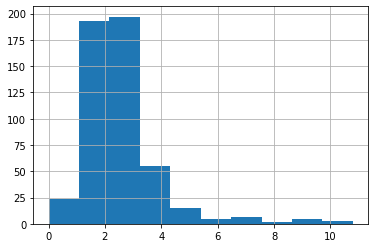

In [86]:
# Create a statistic called undercount rate dividing estimated infections from seroprev by cases. 
state_master_df['undercount_rate'] = state_master_df['Estimated cumulative infections count'] / state_master_df['cumulative_cases']
state_master_df['undercount_rate'].hist();

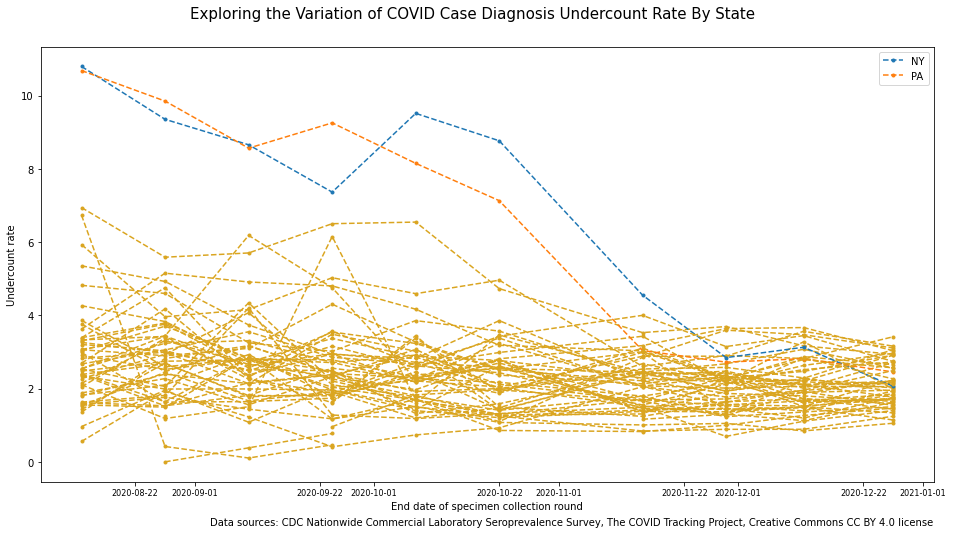

In [175]:
# Create chart of undercount rate by state by time period. 
# This chart essentially puts all of the data on the CDC website into one graph.
fig, ax = plt.subplots(figsize = (16, 8))
for state in state_master_df['state'].unique():
    if float(state_master_df[state_master_df['state']==state][['undercount_rate']].iloc[0]) > 10:
        ax.plot(
            state_master_df[state_master_df['state']==state][['date_range_top_max']], 
            state_master_df[state_master_df['state']==state][['undercount_rate']], 
            label = state,
            ls = '--',
            marker = '.')    
    else:
        ax.plot(
            state_master_df[state_master_df['state']==state][['date_range_top_max']], 
            state_master_df[state_master_df['state']==state][['undercount_rate']], 
            color = 'goldenrod',
            ls = '--',
            marker = '.')    
ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_xlabel('End date of specimen collection round')
ax.set_ylabel('Undercount rate')
ax.legend()
fig.suptitle(f'Exploring the Variation of COVID Case Diagnosis Undercount Rate By State', size=15, y=0.95)
plt.savefig(f'img/undercount_rate_by_state_and_period.png')
plt.figtext(0.9, 0.05, 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right');

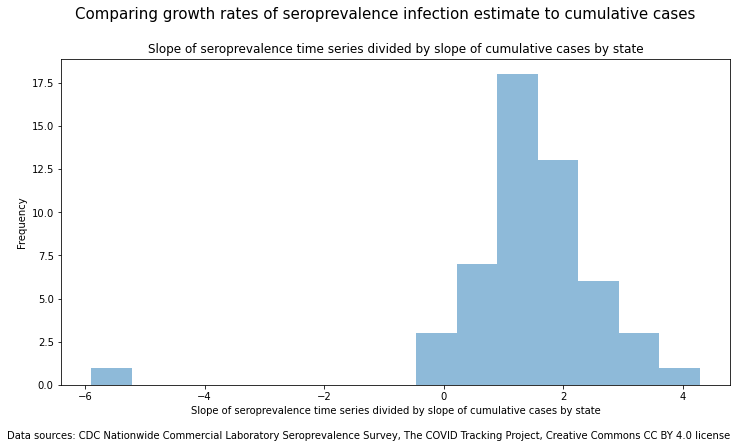

In [88]:
# How does the growth in estimated infections compare to the growth in cumulative cases?
# Divide the slope of the estimated infection time series over the slope of the 
# cumulative cases time series. It should be consistent. We have a problem--New York state. 
    
states, infections_slopes, cases_slopes, slope_compare = [], [], [], []
for state in state_master_df['state'].unique():
    y = state_master_df[state_master_df['state']==state]['Estimated cumulative infections count']
    X = sm.add_constant(state_master_df[state_master_df['state']==state]['Round'])
    y.fillna(y.mean(), axis=0,inplace=True)
    infections_model = sm.OLS(y, X)
    infections_results = infections_model.fit()
    infections_slopes.append(infections_results.params['Round'])
    y2 = state_master_df[state_master_df['state']==state]['cumulative_cases']
    X2 = sm.add_constant(state_master_df[state_master_df['state']==state]['Round'])
    y2.fillna(y2.mean(), axis=0,inplace=True)
    cases_model = sm.OLS(y2, X2)
    cases_results = cases_model.fit()
    cases_slopes.append(cases_results.params['Round'])
    slope_compare.append(infections_results.params['Round'] / cases_results.params['Round'])
    states.append(state)
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(slope_compare, bins=15, alpha=0.5)
ax.set_xlabel('Slope of seroprevalence time series divided by slope of cumulative cases by state')
ax.set_ylabel('Frequency')
ax.set_title('Slope of seroprevalence time series divided by slope of cumulative cases by state')
fig.suptitle(f'Comparing growth rates of seroprevalence infection estimate to cumulative cases', size=15, y=1)
plt.figtext(0.9, 0.0, 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right')
plt.savefig(f'img/slope_comparisons.png');

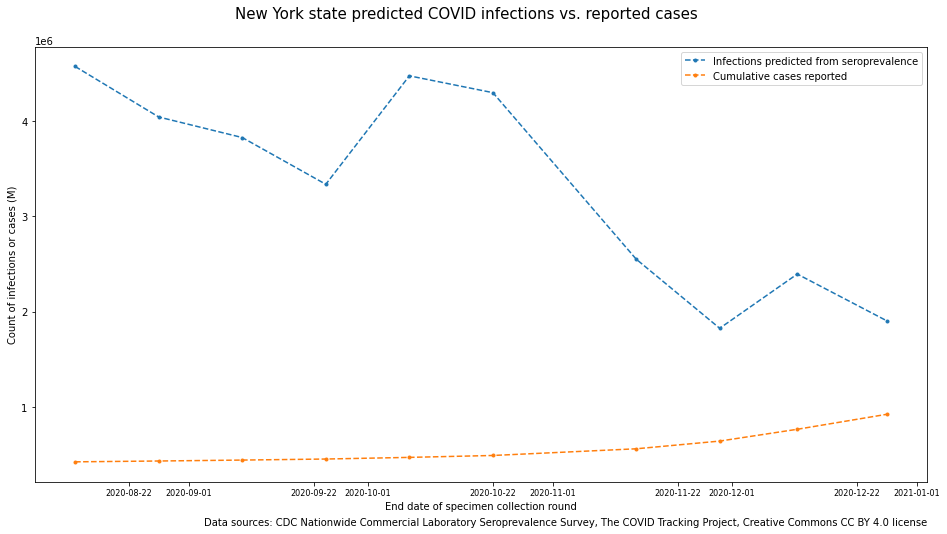

In [174]:
fig, ax = plt.subplots(figsize = (16, 8))
for state in ['NY']:
    ax.plot(
            state_master_df[state_master_df['state']==state][['date_range_top_max']], 
            state_master_df[state_master_df['state']==state][['Estimated cumulative infections count']], 
            label = 'Infections predicted from seroprevalence',
            ls = '--',
            marker = '.')    
    ax.plot(
            state_master_df[state_master_df['state']==state][['date_range_top_max']], 
            state_master_df[state_master_df['state']==state][['cumulative_cases']], 
            label = 'Cumulative cases reported',
            ls = '--',
            marker = '.')    
ax.tick_params(axis='x', which='major', labelsize=8)    
ax.set_xlabel('End date of specimen collection round')
ax.set_ylabel('Count of infections or cases (M)')
ax.legend()
fig.suptitle(f'New York state predicted COVID infections vs. reported cases', size=15, y=0.95)
plt.savefig(f'img/NY_infections_vs_cases.png')
plt.figtext(0.9, 0.05, 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, The COVID Tracking Project, Creative Commons CC BY 4.0 license', horizontalalignment='right');

## Working with age data

In [90]:
# Define a global variable list for the age groupings to be used throughout this notebook.
age_groups_list = ['0_17', '18_49', '50_64', '65_plus']
short_age_groups_list = ['18_49', '50_64', '65_plus']

In [91]:
def point_and_var_calcs(df):
    '''
    Calculates the estimated number of infections and the std error contribution for each stratum in a seroprevalence DataFrame
    Parameters 
    ----------
    df: pandas DataFrame
    Returns
    -------
    df: same Pandas DataFrame with new columns added
    '''
    
    for ages in age_groups_list:
        df[f'n_est_infections_{ages}'] = (df[f'pct_sample_{ages}'] * 
                                              df[f'pop_{ages}']) / 100
        df[f'stratum_std_err_contribution_{ages}'] = (df[f'pop_{ages}']**2 *
                                                     (1- df[f'n_sample_{ages}'] / 
                                                      df[f'pop_{ages}']) * 
                                                     (df[f'n_sample_{ages}'] / 
                                                      (df[f'n_sample_{ages}'] - 1)) * 
                                                     df[f'pct_sample_{ages}']/100 * 
                                                     (1 - df[f'pct_sample_{ages}']/100) / 
                                                     df[f'n_sample_{ages}'])
    return df


In [92]:
# Import seroprevalence by age.
sp_age_df = pd.read_csv('../data/Nationwide_Commercial_Laboratory_Seroprevalence_Survey_December.csv')[
    ['Site','Date Range of Specimen Collection', 'Round', 'Catchment population', 
       'n [0-17 Years Prevalence]', 'n [18-49 Years Prevalence]',
       'n [50-64 Years Prevalence]', 'n [65+ Years Prevalence]',
       'Rate (%) [0-17 Years Prevalence]', 'Rate (%) [18-49 Years Prevalence]',
       'Rate (%) [50-64 Years Prevalence]', 'Rate (%) [65+ Years Prevalence]',
       'Rate (%) [Cumulative Prevalence]', 'Estimated cumulative infections count']]

# Recode 777 and 666 (samples were too small) to nan.
sp_age_df.replace(to_replace=777,value=np.nan,inplace=True)
sp_age_df.replace(to_replace=666,value=np.nan,inplace=True)

sp_age_df.rename(columns={'Catchment population':'N_catchment',
                      'n [0-17 Years Prevalence]':'n_sample_0_17',
                      'n [18-49 Years Prevalence]':'n_sample_18_49',
                      'n [50-64 Years Prevalence]':'n_sample_50_64',
                      'n [65+ Years Prevalence]':'n_sample_65_plus',
                      'Rate (%) [0-17 Years Prevalence]':'pct_sample_0_17',
                      'Rate (%) [18-49 Years Prevalence]':'pct_sample_18_49',
                      'Rate (%) [50-64 Years Prevalence]':'pct_sample_50_64',
                      'Rate (%) [65+ Years Prevalence]':'pct_sample_65_plus',
                      'Estimated cumulative infections count':'n_est_infections_from_table'
                     },inplace=True)

In [93]:
sp_age_df['date_range_close'] = pd.to_datetime(sp_age_df['Date Range of Specimen Collection'].
                                str[-12:].str.strip())
round_dates = (sp_age_df.groupby('Round').agg(
                                date_range_close = ('date_range_close', 'max'))
                                ) 
round_dates.head(2)

,date_range_close
Round,
1,2020-08-13
2,2020-08-27


### Create a usable seroprevalence dataFrame
The seroprevalence DataFrame contains the total population for the state, but it doesn't provide the population by age group for each state. If we know the population by age for each state then we can calculate the total estimated infections by age and state from the infection rate by age that is provided in the seroprevalence DataFrame. We can use these estimates to calculate summary statistics such as the weighted average undercount rate (possibly with confidence intervals). 

We can obtain population by age and state from Census data and then merge the population data with the seroprevalence DataFrame to create a comprehensive DataFrame. Prior to merging the tables, we need to sum up the populations to create census age groupings that match the seroprevalence age groupings.

Source: https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-detail.html

In [94]:
# Loading in state census by age data
state_census = pd.read_csv('../data/sc-est2019-agesex-civ.csv')
state_census = state_census[state_census['SEX']==0][['STATE','NAME','AGE','POPEST2019_CIV']]

pop_grouped = state_census.groupby('STATE').agg(st_fips = ('STATE', 'max'),
                                                  st_name = ('NAME', 'max')).reset_index()
del pop_grouped['STATE']
pop_grouped['pop_0_17'] = (state_census[state_census['AGE'].isin(range(0,18))].
                   groupby('STATE').sum()['POPEST2019_CIV'].reset_index())['POPEST2019_CIV']
pop_grouped['pop_18_49'] = (state_census[state_census['AGE'].isin(range(18,50))].
                   groupby('STATE')['POPEST2019_CIV'].sum().reset_index())['POPEST2019_CIV']
pop_grouped['pop_50_64'] = (state_census[state_census['AGE'].isin(range(50,65))].
                   groupby('STATE')['POPEST2019_CIV'].sum().reset_index())['POPEST2019_CIV']
pop_grouped['pop_65_plus'] = (state_census[state_census['AGE'].isin(range(65,100))].
                     groupby('STATE')['POPEST2019_CIV'].sum().reset_index())['POPEST2019_CIV']

We need to merge (join) the seroprevalence DataFrame with the census table DataFrame ('pop_grouped'), but the state field in the seroprevalence table ('Site') does not match the format of the state fields in the census table ('st+abbr' or 'st_name'). We are going to need to upload a table which contains state values which are common to both, and use that table to join the other two together. One of many tables that will work comes from the COVID Tracking Project. We will use that one here.

In [95]:
# Step 1. Load in the COVID Tracking Project dataset to facilitate merging seroprevalence and census DataFrames.
state_merge_df = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")[
                                ['state', 'fips']]

In [96]:
# Step 2. Merge COVID Tracking Project DataFrame with census DataFrame by fips code which will populate census DataFrame with state two-letter abbreviation. 
pop_grouped = pop_grouped.merge(state_merge_df.groupby('state').max().reset_index(), 
                                           left_on = 'st_fips', right_on = 'fips')[
                ['st_name', 'state', 'fips', 'pop_0_17', 'pop_18_49',
                 'pop_50_64', 'pop_65_plus']]

In [97]:
# Step 3. Finally, merge census DataFrame from step 2 to populate seroprevalence DataFrame with census data by age and state.
sp_and_census_df = sp_age_df.merge(pop_grouped, left_on = 'Site', right_on = 'state')

### Aggregating by seroprevalence round
Let's now aggregate the data by seroprevalence rounds (i.e. batches). Once this is done we will adjust the counts upwards to compensate for missing data.

In [98]:
# Step 4. Calculates the estimated number of infections in each site/time period.
# Note, variance statistics are calculated as well, but we won't use them.
sp_and_census_df = point_and_var_calcs(sp_and_census_df)

In [99]:
# Aggregate by round to get estimated infections by age group by round.
sp_by_round_df = sp_and_census_df.groupby('Round').agg(
                                    pop_0_17 = ('pop_0_17', 'sum'),
                                    pop_18_49 = ('pop_18_49', 'sum'),
                                    pop_50_64 = ('pop_50_64', 'sum'),
                                    pop_65_plus = ('pop_65_plus', 'sum'),
                                    n_est_infections_0_17 = ('n_est_infections_0_17', 'sum'),
                                    n_est_infections_18_49 = ('n_est_infections_18_49', 'sum'),
                                    n_est_infections_50_64 = ('n_est_infections_50_64', 'sum'),
                                    n_est_infections_65_plus = ('n_est_infections_65_plus', 'sum'),
                                    n_est_infections_from_table = ('n_est_infections_from_table', 'sum'),
                                    last_date_of_round = ('date_range_close', 'max')
                                ).reset_index()

In [100]:
# Slight upward adjustment to counts to compensate for missing data
sp_by_round_df['pct_age_data_missing'] = (sp_by_round_df['n_est_infections_from_table'] - 
                                       sp_by_round_df['n_est_infections_0_17'] - 
                                       sp_by_round_df['n_est_infections_18_49'] - 
                                       sp_by_round_df['n_est_infections_50_64'] - 
                                       sp_by_round_df['n_est_infections_65_plus'] ) / sp_by_round_df['n_est_infections_from_table']

for ages in age_groups_list:
    sp_by_round_df[f'Est infections (from sp), {ages}'] = (sp_by_round_df[f'n_est_infections_{ages}'] / 
                                    sp_by_round_df[f'pop_{ages}'] / (1-sp_by_round_df['pct_age_data_missing']))

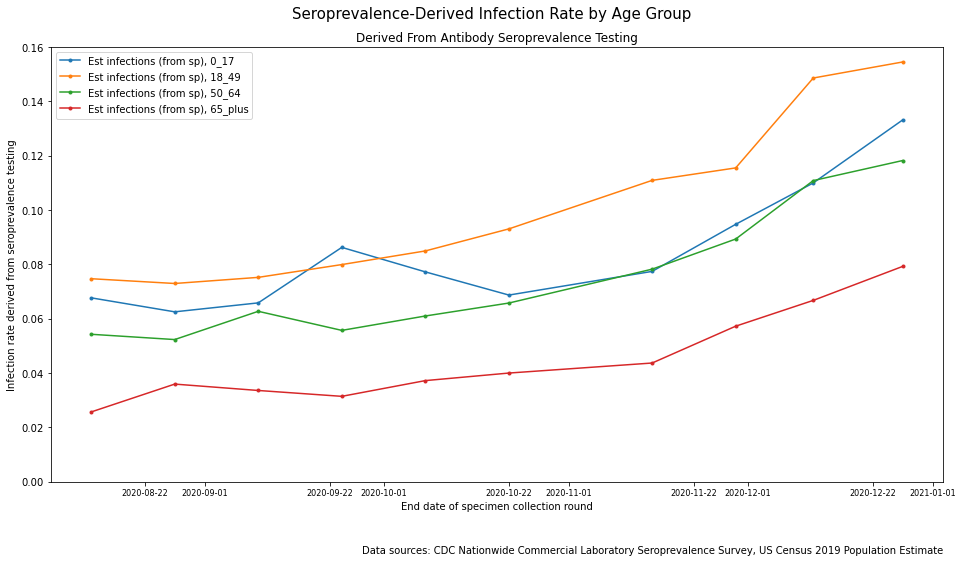

In [173]:
# Let's see what we have now.
fig, ax = plt.subplots(figsize = (16, 8))

for ages in age_groups_list:
    col_name = f'Est infections (from sp), {ages}'
    ax.plot(sp_by_round_df['last_date_of_round'],
            sp_by_round_df[col_name], 
            label = col_name,
            marker = '.')

ax.set_ylim(0,0.16)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_xlabel('End date of specimen collection round')
ax.set_ylabel('Infection rate derived from seroprevalence testing')
ax.set_title('Derived From Antibody Seroprevalence Testing')
ax.legend()
fig.suptitle(f'    Seroprevalence-Derived Infection Rate by Age Group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate', horizontalalignment='right');
plt.savefig(f'img/seroprev_by_age_and_period.png')

In [102]:
# The time series are mostly well-behaved except the '0-17' line has a couple outliers.
# A lack of sufficient samples in the '0-17' age group led to no 
# prevalence estimate in 43% of the state/time period sites.

print('\nPercent state/time period insufficient data\n')
for i in age_groups_list:
#     print(1-round(sp_age_df[f"pct_sample_{i}"].count() / len(sp_age_df)))
    print(f"Age group '{i}':  \t", 100-round(sp_age_df[f"pct_sample_{i}"].count()/len(sp_age_df)*100), f'%')


Percent state/time period insufficient data

Age group '0_17':  	 43 %
Age group '18_49':  	 6 %
Age group '50_64':  	 7 %
Age group '65_plus':  	 8 %


## Removing troublesome data--NY state and '0-17' age group

In [110]:
# Remove NY and then recreate seroprev time series.
sp_and_census_df_no_NY = sp_and_census_df[sp_and_census_df['Site'] != 'NY']
sp_and_census_df_no_NY = point_and_var_calcs(sp_and_census_df_no_NY)

In [111]:
# Aggregate by round to get estimated infections by age group by round.
sp_by_round_df_no_NY = sp_and_census_df_no_NY.groupby('Round').agg(
                                    pop_0_17 = ('pop_0_17', 'sum'),
                                    pop_18_49 = ('pop_18_49', 'sum'),
                                    pop_50_64 = ('pop_50_64', 'sum'),
                                    pop_65_plus = ('pop_65_plus', 'sum'),
                                    n_est_infections_0_17 = ('n_est_infections_0_17', 'sum'),
                                    n_est_infections_18_49 = ('n_est_infections_18_49', 'sum'),
                                    n_est_infections_50_64 = ('n_est_infections_50_64', 'sum'),
                                    n_est_infections_65_plus = ('n_est_infections_65_plus', 'sum'),
                                    n_est_infections_from_table = ('n_est_infections_from_table', 'sum'),
                                    last_date_of_round = ('date_range_close', 'max')
                                ).reset_index()

In [112]:
# Slight upward adjustment to counts to compensate for missing data
sp_by_round_df_no_NY['pct_age_data_missing'] = (sp_by_round_df_no_NY['n_est_infections_from_table'] - 
                                       sp_by_round_df_no_NY['n_est_infections_0_17'] - 
                                       sp_by_round_df_no_NY['n_est_infections_18_49'] - 
                                       sp_by_round_df_no_NY['n_est_infections_50_64'] - 
                                       sp_by_round_df_no_NY['n_est_infections_65_plus'] ) / sp_by_round_df['n_est_infections_from_table']

for ages in age_groups_list:
    sp_by_round_df_no_NY[f'Est infections (from sp), {ages}'] = (sp_by_round_df_no_NY[f'n_est_infections_{ages}'] / 
                                    sp_by_round_df_no_NY[f'pop_{ages}'] / (1-sp_by_round_df_no_NY['pct_age_data_missing']))

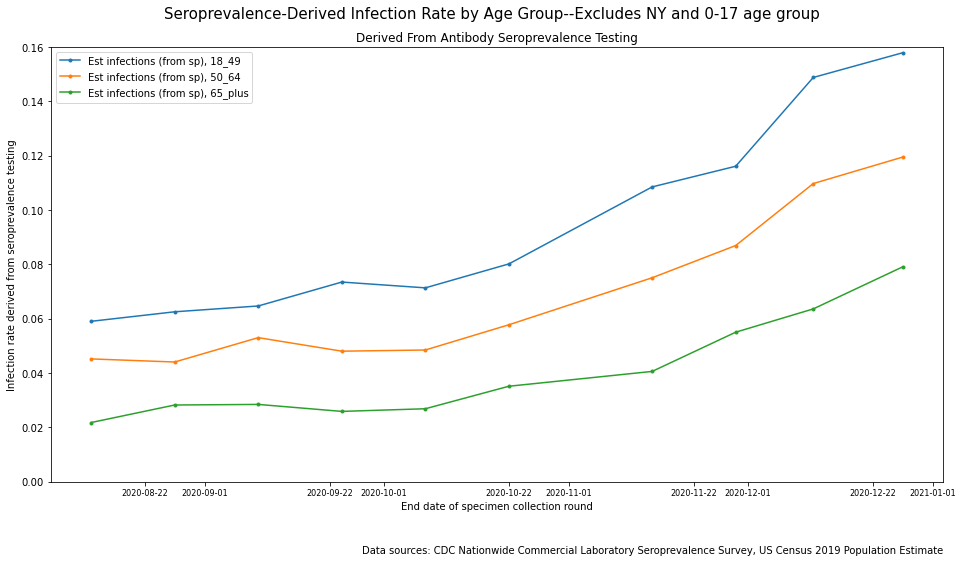

In [172]:
# Let's see what we have now.
fig, ax = plt.subplots(figsize = (16, 8))

for ages in short_age_groups_list:
    col_name = f'Est infections (from sp), {ages}'
    ax.plot(sp_by_round_df_no_NY['last_date_of_round'],
            sp_by_round_df_no_NY[col_name], 
            label = col_name,
            marker = '.')

ax.set_ylim(0,0.16)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_xlabel('End date of specimen collection round')
ax.set_ylabel('Infection rate derived from seroprevalence testing')
ax.set_title('Derived From Antibody Seroprevalence Testing')
ax.legend()
fig.suptitle(f'    Seroprevalence-Derived Infection Rate by Age Group--Excludes NY and 0-17 age group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate', horizontalalignment='right');
plt.savefig(f'img/seroprev_by_age_and_period_with_exclusions.png')

In [153]:
# Unfortunately, we don't have access to a case dataset that has cases by day both age and state.
# Dropping NY state data from a dataset with age data will require an approximation based on NY share. 
NY_case_share = state_master_df[state_master_df['state']=='NY'].groupby('Round').agg(
                            NY_share = ('cumulative_cases', 'sum')) / state_master_df.groupby('Round').agg(
                            NY_share = ('cumulative_cases', 'sum'))
NY_case_share.head(2)

,NY_share
Round,
1,0.081338
2,0.074282


### Loading and preparing case diagnosis data for comparison 

Now we need to do the same thing with the case data--calculate the case rate by age group. Let's start by summing up cumulative cases for each age group in the CDC data. We'll loop through the data 8 times--once for each of the specimen collection rounds. For each loop, we'll cut off the count at the date corresponding to that particular specimen collection round's cutoff date. Finally, we will transpose our table and then convert the age groups from the CDC data to match the age groups for the seroprevalence data.

We're also going to need to pull in estimated population from the US Census so we can calculate case diagnosis infection rates.

In [114]:
rows_ = 10000000 #dataset is large. Need to limit rows and/or columns to load.
CDC_case_df1 = pd.read_csv('../data/COVID-19_Case_Surveillance_Public_Use_Data_Feb_2021.csv', 
                          usecols=[0,5,6], encoding='latin-1', nrows=rows_, skiprows=1, header=None)
CDC_case_df2 = pd.read_csv('../data/COVID-19_Case_Surveillance_Public_Use_Data_Feb_2021.csv', 
                          usecols=[0,5,6], encoding='latin-1', nrows=rows_, skiprows=10000001, header=None)
# Source: https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data/vbim-akqf/data

In [115]:
CDC_case_df = pd.concat([CDC_case_df1, CDC_case_df2], ignore_index=True)

In [116]:
CDC_case_df.columns = ['cdc_case_earliest_dt ', 'sex', 'age_group']

In [117]:
CDC_case_df = CDC_case_df[CDC_case_df['age_group']!='Missing'] # less than 1% unknowns, so drop them.

In [128]:
# Create a new DataFrame with each cases by age_groups in rows and by round in columns. Transpose to orient properly.
age_group_df = pd.DataFrame(CDC_case_df['age_group'].unique(), columns=['age_group'])
round_ = 1

for date_ in sp_by_round_df['last_date_of_round']:
    curr_case_df = (CDC_case_df[pd.to_datetime(CDC_case_df['cdc_case_earliest_dt ']) < date_].
                    groupby('age_group').count()
                    )
    curr_case_df = curr_case_df.rename(columns={'sex': round_})[round_].reset_index()
    round_ +=1
    age_group_df = age_group_df.merge(curr_case_df, on='age_group')

age_group_df = age_group_df.T
age_group_df.columns = age_group_df.iloc[0]
age_group_df = age_group_df[1:]
age_group_df = age_group_df.reset_index().rename(columns={'index':'Round'})

In [160]:
remainder = 1 - NY_case_share
age_group_df_no_NY = remainder.values * age_group_df.iloc[:,1:]
age_group_df_no_NY['Round'] = [1,2,3,4,5,6,7,8,9,10]

In [161]:
# Aligning case count age groups with seroprevalence age groups.
age_group_df_no_NY['cases_0_17'] = (age_group_df_no_NY['0 - 9 Years'] + 
                              4/5 * age_group_df_no_NY['10 - 19 Years'])
age_group_df_no_NY['cases_18_49'] = (1/5 * age_group_df_no_NY['10 - 19 Years'] + 
                               age_group_df_no_NY['20 - 29 Years'] + 
                               age_group_df_no_NY['30 - 39 Years'] +
                               age_group_df_no_NY['40 - 49 Years'])
age_group_df_no_NY['cases_50_64'] = (age_group_df_no_NY['50 - 59 Years'] + 
                               1/2 * age_group_df_no_NY['60 - 69 Years'])
age_group_df_no_NY['cases_65_plus'] = (1/2* age_group_df_no_NY['60 - 69 Years'] + 
                               age_group_df_no_NY['70 - 79 Years'] + 
                               age_group_df_no_NY['80+ Years'])

### Comparing antibody seroprevalence counts to antigen diagnostic case counts

In [162]:
sp_by_round_df_no_NY

,Round,pop_0_17,pop_18_49,pop_50_64,pop_65_plus,n_est_infections_0_17,n_est_infections_18_49,n_est_infections_50_64,n_est_infections_65_plus,n_est_infections_from_table,last_date_of_round,pct_age_data_missing,"Est infections (from sp), 0_17","Est infections (from sp), 18_49","Est infections (from sp), 50_64","Est infections (from sp), 65_plus"
0,1,69009638,128817962,59034268,50762117,3585787.465,7.210802e+06,2530214.240,1049408.782,15416159.0,2020-08-13,0.052030,0.054813,0.059049,0.045213,0.021808
1,2,69009638,128817962,59034268,50762117,3346465.342,7.721474e+06,2493299.661,1374499.462,15761065.0,2020-08-27,0.041678,0.050602,0.062548,0.044072,0.028255
2,3,69009638,128817962,59034268,50762117,3934942.455,8.114981e+06,3049105.509,1407473.920,17052717.0,2020-09-10,0.026162,0.058552,0.064688,0.053037,0.028472
3,4,69009638,128817962,59034268,50762117,5225019.789,9.168314e+06,2747517.028,1273340.039,19121889.0,2020-09-24,0.031513,0.078178,0.073489,0.048055,0.025901
4,5,69009638,128817962,59034268,50762117,4691003.681,8.672578e+06,2700802.846,1287251.637,18659163.0,2020-10-08,0.056524,0.072049,0.071358,0.048491,0.026878
5,6,69009638,128817962,59034268,50762117,4041304.067,1.007117e+07,3326211.923,1740564.493,19775212.0,2020-10-22,0.024758,0.060048,0.080166,0.057774,0.035159
6,7,69009638,128817962,59034268,50762117,4326957.322,1.253471e+07,3974432.981,1848924.251,25586437.0,2020-11-15,0.103118,0.069910,0.108493,0.075065,0.040611
7,8,69009638,128817962,59034268,50762117,6223461.537,1.402809e+07,4813294.840,2620784.157,29636190.0,2020-11-29,0.062000,0.096143,0.116097,0.086923,0.055041
8,9,69009638,128817962,59034268,50762117,6884282.639,1.760111e+07,5949556.471,2965748.379,36577986.0,2020-12-12,0.081529,0.108613,0.148764,0.109727,0.063611
9,10,69009638,128817962,59034268,50762117,8738324.869,1.929840e+07,6693392.153,3810641.006,40714653.0,2020-12-27,0.051009,0.133431,0.157864,0.119476,0.079104


In [163]:
# Merge the two distinct DataFrames
sp_by_case_df_no_NY = sp_by_round_df_no_NY.merge(age_group_df_no_NY, on='Round')

In [164]:
sp_by_case_df_no_NY

,Round,pop_0_17,pop_18_49,pop_50_64,pop_65_plus,n_est_infections_0_17,n_est_infections_18_49,n_est_infections_50_64,n_est_infections_65_plus,n_est_infections_from_table,...,30 - 39 Years,40 - 49 Years,50 - 59 Years,60 - 69 Years,70 - 79 Years,80+ Years,cases_0_17,cases_18_49,cases_50_64,cases_65_plus
0,1,69009638,128817962,59034268,50762117,3585787.465,7.210802e+06,2530214.240,1049408.782,15416159.0,...,699066,645186,624674,434047,242668,223644,378862,2.19e+06,841698,683335
1,2,69009638,128817962,59034268,50762117,3346465.342,7.721474e+06,2493299.661,1374499.462,15761065.0,...,775927,715010,690640,478582,267760,241900,446007,2.45072e+06,929931,748951
2,3,69009638,128817962,59034268,50762117,3934942.455,8.114981e+06,3049105.509,1407473.920,17052717.0,...,843612,777859,750737,520278,291714,259550,518133,2.70325e+06,1.01088e+06,811403
3,4,69009638,128817962,59034268,50762117,5225019.789,9.168314e+06,2747517.028,1273340.039,19121889.0,...,911836,839768,810948,562179,315713,276054,584781,2.94161e+06,1.09204e+06,872857
4,5,69009638,128817962,59034268,50762117,4691003.681,8.672578e+06,2700802.846,1287251.637,18659163.0,...,994761,915404,885112,616287,347506,296988,658641,3.2182e+06,1.19326e+06,952638
5,6,69009638,128817962,59034268,50762117,4041304.067,1.007117e+07,3326211.923,1740564.493,19775212.0,...,1.10666e+06,1.01848e+06,987284,690105,389670,324825,750513,3.58072e+06,1.33234e+06,1.05955e+06
6,7,69009638,128817962,59034268,50762117,4326957.322,1.253471e+07,3974432.981,1848924.251,25586437.0,...,1.45494e+06,1.33731e+06,1.29483e+06,910278,510915,404129,1.03385e+06,4.70621e+06,1.74997e+06,1.37018e+06
7,8,69009638,128817962,59034268,50762117,6223461.537,1.402809e+07,4813294.840,2620784.157,29636190.0,...,1.72414e+06,1.58393e+06,1.53605e+06,1.08399e+06,607740,469675,1.24741e+06,5.56107e+06,2.07805e+06,1.61941e+06
8,9,69009638,128817962,59034268,50762117,6884282.639,1.760111e+07,5949556.471,2965748.379,36577986.0,...,2.04371e+06,1.87259e+06,1.81457e+06,1.28225e+06,715709,546276,1.50538e+06,6.56711e+06,2.45569e+06,1.90311e+06
9,10,69009638,128817962,59034268,50762117,8738324.869,1.929840e+07,6693392.153,3810641.006,40714653.0,...,2.36327e+06,2.16576e+06,2.10379e+06,1.48997e+06,828747,624595,1.75758e+06,7.56467e+06,2.84877e+06,2.19833e+06


In [165]:
# Calculating the case undercount rates
for ages in age_groups_list:
    sp_by_case_df_no_NY[f'Est infections (from cases), {ages}'] = (sp_by_case_df_no_NY[f'cases_{ages}'] / sp_by_case_df_no_NY[f'pop_{ages}'])
    sp_by_case_df_no_NY[f'Undercount rate, {ages}'] = (sp_by_case_df_no_NY[f'n_est_infections_{ages}'] / 
                                       sp_by_case_df_no_NY[f'cases_{ages}'])


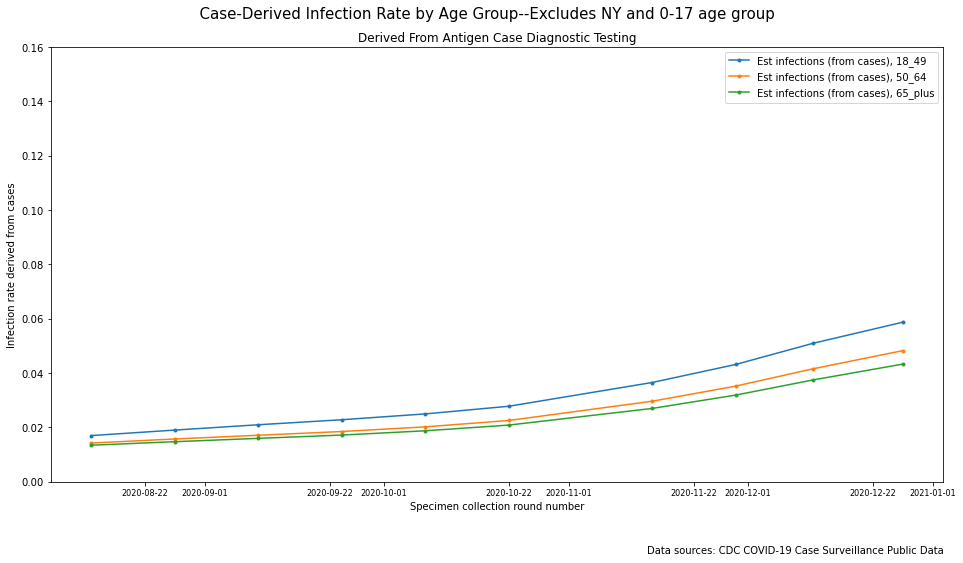

In [169]:
# Chart case-derived estimate of infection rate by age group
fig, ax = plt.subplots(figsize = (16, 8))

for ages in short_age_groups_list:
    col_name = f'Est infections (from cases), {ages}'
    ax.plot(sp_by_case_df_no_NY['last_date_of_round'],
            sp_by_case_df_no_NY[col_name], 
            label = col_name,
            marker = '.')

ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_ylim(0,0.16)
ax.set_xlabel('End date of specimen collection round')
ax.set_ylabel('Infection rate derived from cases')
ax.set_title('Derived From Antigen Case Diagnostic Testing')
ax.legend()
fig.suptitle(f'  Case-Derived Infection Rate by Age Group--Excludes NY and 0-17 age group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC COVID-19 Case Surveillance Public Data', horizontalalignment='right')
plt.savefig(f'img/cases_by_age_and_period_with_exclusions.png');

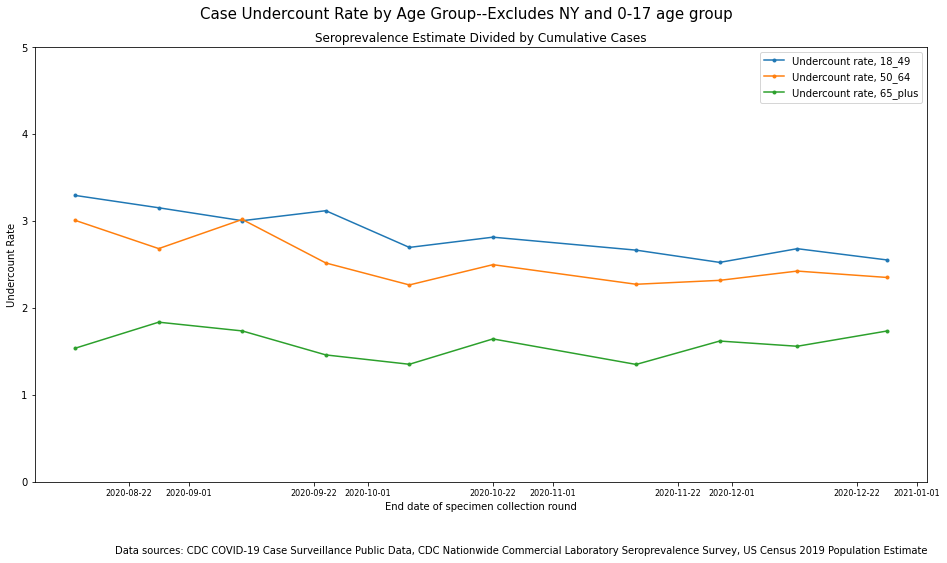

In [171]:
fig, ax = plt.subplots(figsize = (16, 8))

for ages in short_age_groups_list:
    col_name = f'Undercount rate, {ages}'
    ax.plot(sp_by_case_df_no_NY['last_date_of_round'],
            sp_by_case_df_no_NY[col_name], 
            label = col_name,
            marker = '.')

ax.tick_params(axis='x', which='major', labelsize=8)
ax.set_ylim(0,5)
ax.set_xlabel('End date of specimen collection round')
ax.set_ylabel('Undercount Rate')
ax.set_title('Seroprevalence Estimate Divided by Cumulative Cases')
ax.legend()
fig.suptitle(f'Case Undercount Rate by Age Group--Excludes NY and 0-17 age group', size=15, y=0.95)
plt.figtext(0.9, 0, 'Data sources: CDC COVID-19 Case Surveillance Public Data, CDC Nationwide Commercial Laboratory Seroprevalence Survey, US Census 2019 Population Estimate', horizontalalignment='right')
plt.savefig(f'img/undercount_by_age_and_period_with_exclusions.png');

In [ ]:
#